In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc('savefig', dpi=300)

# References
# https://www.python-engineer.com/posts/apple-health-data-python/
# https://www.relevantmisc.com/r/python/2020/05/26/visualizing-baby-sleep/
# https://stackoverflow.com/questions/72989080/how-to-make-plots-in-python-like-the-sleep-schedule-plot-in-ios-health-app

In [2]:
# Path to the XML file exported form Apple Health app
XML_DATA = "../apple_data/apple_health_export/export.xml"

In [3]:
# Parse XML file exported from Apple Health app
tree = ET.parse(XML_DATA)
root = tree.getroot()

# Store "Record" type data into Pandas.DataFrame
records = [i.attrib for i in root.iter("Record")]
records_df = pd.DataFrame(records)

# Convert datetime format
date_col = ['creationDate', 'startDate', 'endDate']
records_df[date_col] = records_df[date_col].apply(pd.to_datetime) 

# Select Sleep Analysis records
sleeps_df = records_df.query("type == 'HKCategoryTypeIdentifierSleepAnalysis'")

# Cut overnight records into two separate records
no_cross = sleeps_df[sleeps_df["startDate"].dt.day == sleeps_df["endDate"].dt.day]
cross = sleeps_df[sleeps_df["startDate"].dt.day != sleeps_df["endDate"].dt.day]
c1 = cross.copy()
c2 = cross.copy()
c1["endDate"] = c1["startDate"].apply(lambda x: x.replace(hour=23, minute=59, second=59))
c2["startDate"] = c2["endDate"].apply(lambda x: x.replace(hour=0, minute=0, second=0))
sleeps_splitted_df = pd.concat([no_cross, c1, c2]).sort_values("startDate")

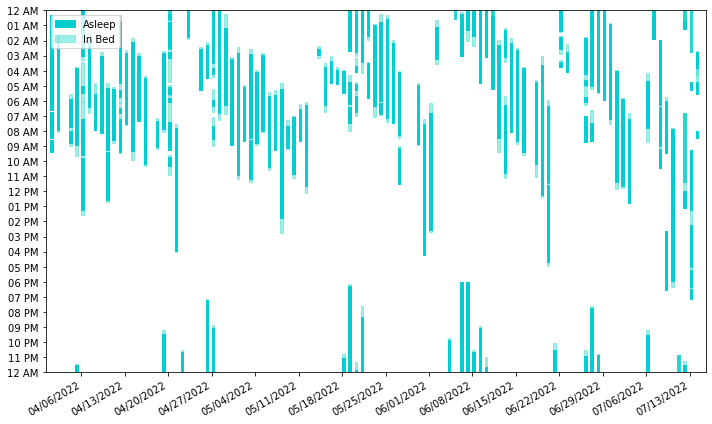

In [5]:
# Select plotting starting date
# x = sleeps_splitted_df[sleeps_splitted_df["startDate"] > pd.Timestamp(2022, 1, 1).tz_localize(tz="US/Central") ]
# x = sleeps_splitted_df[sleeps_splitted_df["startDate"] > pd.Timestamp(2022, 6, 1).tz_localize(tz="US/Central") ]
x = sleeps_splitted_df[sleeps_splitted_df["startDate"] > pd.Timestamp(2022, 4, 1).tz_localize(tz="US/Central") ]

# Plotting
# fig = plt.figure(figsize=(20, 6))  # better for a year
fig = plt.figure(figsize=(10, 6))  # better for a few months 

ax = fig.add_subplot()

width = 0.4
color_dict = {"HKCategoryValueSleepAnalysisAsleep": 'darkturquoise', "HKCategoryValueSleepAnalysisInBed": 'turquoise', "HKCategoryValueSleepAnalysisAwake": "red"}
alpha_dict = {"HKCategoryValueSleepAnalysisAsleep": 1, "HKCategoryValueSleepAnalysisInBed": 0.5, "HKCategoryValueSleepAnalysisAwake": 0.2}

for row in x.itertuples(index=False):
    # Skip "Awake" for plotting
    if row.value == "HKCategoryValueSleepAnalysisAwake":
        continue
    
    # Timestemp at the begining of the startDate's day
    row_date = row.startDate.replace(hour=0, minute=0, second=0)

    # Plot rectangle patches ((x0, y0), width, hight)
    rect = matplotlib.patches.Rectangle((mdates.date2num(row.startDate.date()), mdates.date2num(row.startDate-row_date)/1000),
                                        width,
                                        mdates.date2num(row.endDate-row.startDate)/1000,
                                        color=color_dict[row.value],
                                        alpha=alpha_dict[row.value])
    ax.add_patch(rect)

# Generate legend
legend_patches = [
    matplotlib.patches.Patch(color=color_dict["HKCategoryValueSleepAnalysisAsleep"], alpha=alpha_dict["HKCategoryValueSleepAnalysisAsleep"], label="Asleep"),
    matplotlib.patches.Patch(color=color_dict["HKCategoryValueSleepAnalysisInBed"], alpha=alpha_dict["HKCategoryValueSleepAnalysisInBed"], label="In Bed")
]
plt.legend(loc=2, handles=legend_patches)

# Plot range for current data range
plt.xlim(mdates.date2num(x["startDate"].min())-1, mdates.date2num(x["endDate"].max())+1)
plt.ylim(1,0)

# Set Ticks
# plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
plt.gca().yaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()

plt.tight_layout()
# plt.savefig("sleep_plot.pdf")
plt.savefig("sleep_plot@2x.png")
